In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
SEED = 42

pd.set_option('display.max_rows', 50)

In [2]:
factor = '0.0001'
factor2 = '0.00001'
regularizer_list = [
    {'input': f'L21_{factor}', 'hidden': None,          'bias': None},
    {'input': f'L21_{factor}', 'hidden': f'L21_{factor}', 'bias': None},
    {'input':  f'L1_{factor}', 'hidden': None,          'bias': None},
    {'input':  f'L1_{factor2}',  'hidden': f'L1_{factor2}', 'bias': None},
]

ratio = 0.10

weights_list = []
name_list   = []
for regularizer in regularizer_list:
    
    input = regularizer.get("input")
    input_name = input.split('_')[0] if input else None
    hidden = regularizer.get("hidden")
    hidden_name = input.split('_')[0] if hidden else None
    name = f'{input_name}, {hidden_name}'
    
    weights_list.append(pd.read_csv(f'./weights/SLSTM_UP_AUGMENT_ONLY_5_64_3_64_Adam_0.001_{input}_{hidden}_None_10_(11528, 21, 498).csv',
                                    index_col=0, names = [name], header = 0))
    name_list.append(name)
    
weights = pd.concat(weights_list, axis=1)

top_weights = pd.concat([weights[name].sort_values(ascending = True)[:int(len(weights)*ratio)] for name in weights.columns], axis=1)    
weight_scores = (top_weights > 0)

min_score = 4
score_idx = (weight_scores.sum(axis=1) >= min_score)
selected_features = list(top_weights[score_idx].index)

display(top_weights[score_idx].mean(1).sort_values(ascending=False))


# min_score = 3
# score_idx = (weight_scores.sum(axis=1) >= min_score)

# display(top_weights[score_idx])

number_phe_15A                     0.003780
number_positive_20A                0.003677
number_aromatic_15A                0.003221
number_aromatic_20A                0.003187
number_f_non_polar_aromatic_20A    0.003132
number_e_non_polar_suffered_10A    0.003090
number_f_non_polar_aromatic_15A    0.003077
number_small_15A                   0.003076
number_trp_15A                     0.003052
number_cys_10A                     0.003030
sasa_cys_0A                        0.002997
number_small_20A                   0.002912
number_normal_20A                  0.002829
number_hydrophilic_20A             0.002254
sasa_trp_0A                        0.001172
dtype: float64

In [3]:
from ml_models import *
from functions import *

data_dir = './data/integrated_features' # we will get names from the augmented proteins
protein_names = [x.split('.')[0] for x in os.listdir(data_dir) if x.split('.')[1] == 'csv'] # get protein name list to be processed for building machine learning models
print('the number of initial proteins:', len(protein_names))

initial_params = default_params.copy()
initial_params.update({
    'window_size'    : 10
    })

augmented_columns = dict(pd.read_csv('./data/augmented_columns.csv', header=0).values.squeeze())
print('# of augmented features:', len(augmented_columns))

# set continuous input features
x_cts = [x for x in augmented_columns.keys() if augmented_columns.get(x) != 'object']

# set categorical input features
x_cat = [x for x in augmented_columns.keys() if augmented_columns.get(x) == 'object']

# input features
x_var = x_cts + x_cat

# set continuos output feature
y_cts = []

# set categorical output feature
y_cat = ['positivity']

# output features
y_var = y_cts + y_cat

data_x = []
data_y = []
for name in protein_names:
    data = pd.read_csv(f'./data/integrated_features/{name}.csv')
    ST_idx = np.where((data['residue'] == 'S') | (data['residue'] == 'T'))[0]
    
    # get X dataset
    x_onehot = get_onehots(data[x_var], columns = x_cat)
    x_features = list(x_onehot.columns)
    
    # get Y dataset
    y_onehot = get_onehots(data[y_var], columns = y_cat)
    y_labels = list(y_onehot.columns)
    
    for idx in ST_idx:
        window_x = np.array(get_window(x_onehot, idx, initial_params['window_size']))
        label_y  = np.array(y_onehot.iloc[idx])
        
        data_x.append(window_x)
        data_y.append(label_y)
        
data_x = np.array(data_x)
data_y = np.array(data_y)

print('data x shape: ', data_x.shape)
print('data y shape: ', data_y.shape)

the number of initial proteins: 104
# of augmented features: 498
data x shape:  (11528, 21, 498)
data y shape:  (11528, 2)


In [4]:
selected_x = data_x[:, :, [x_features.index(x) for x in selected_features]]
selected_x.shape

(11528, 21, 15)

In [5]:
x_min = selected_x.min(0).min(0)
x_max = selected_x.max(0).max(0)

In [6]:
pos_x = selected_x[data_y[:,0] == 0]
neg_x = selected_x[data_y[:,0] == 1]
pos_x.shape

(428, 21, 15)

In [7]:
pos_x_sc = (pos_x.mean(0) - x_min) / (x_max - x_min)
neg_x_sc = (neg_x.mean(0) - x_min) / (x_max - x_min)

In [8]:
pos_df = pd.DataFrame(pos_x_sc.round(3),
             index   = range(-10,11),
             columns = selected_features)

neg_df = pd.DataFrame(neg_x_sc.round(3),
             index   = range(-10,11),
             columns = selected_features)

In [9]:
from graphplotlib import *

In [10]:
selected_features

['sasa_cys_0A',
 'number_cys_10A',
 'number_e_non_polar_suffered_10A',
 'sasa_trp_0A',
 'number_hydrophilic_20A',
 'number_trp_15A',
 'number_small_15A',
 'number_aromatic_15A',
 'number_f_non_polar_aromatic_15A',
 'number_small_20A',
 'number_positive_20A',
 'number_normal_20A',
 'number_aromatic_20A',
 'number_phe_15A',
 'number_f_non_polar_aromatic_20A']

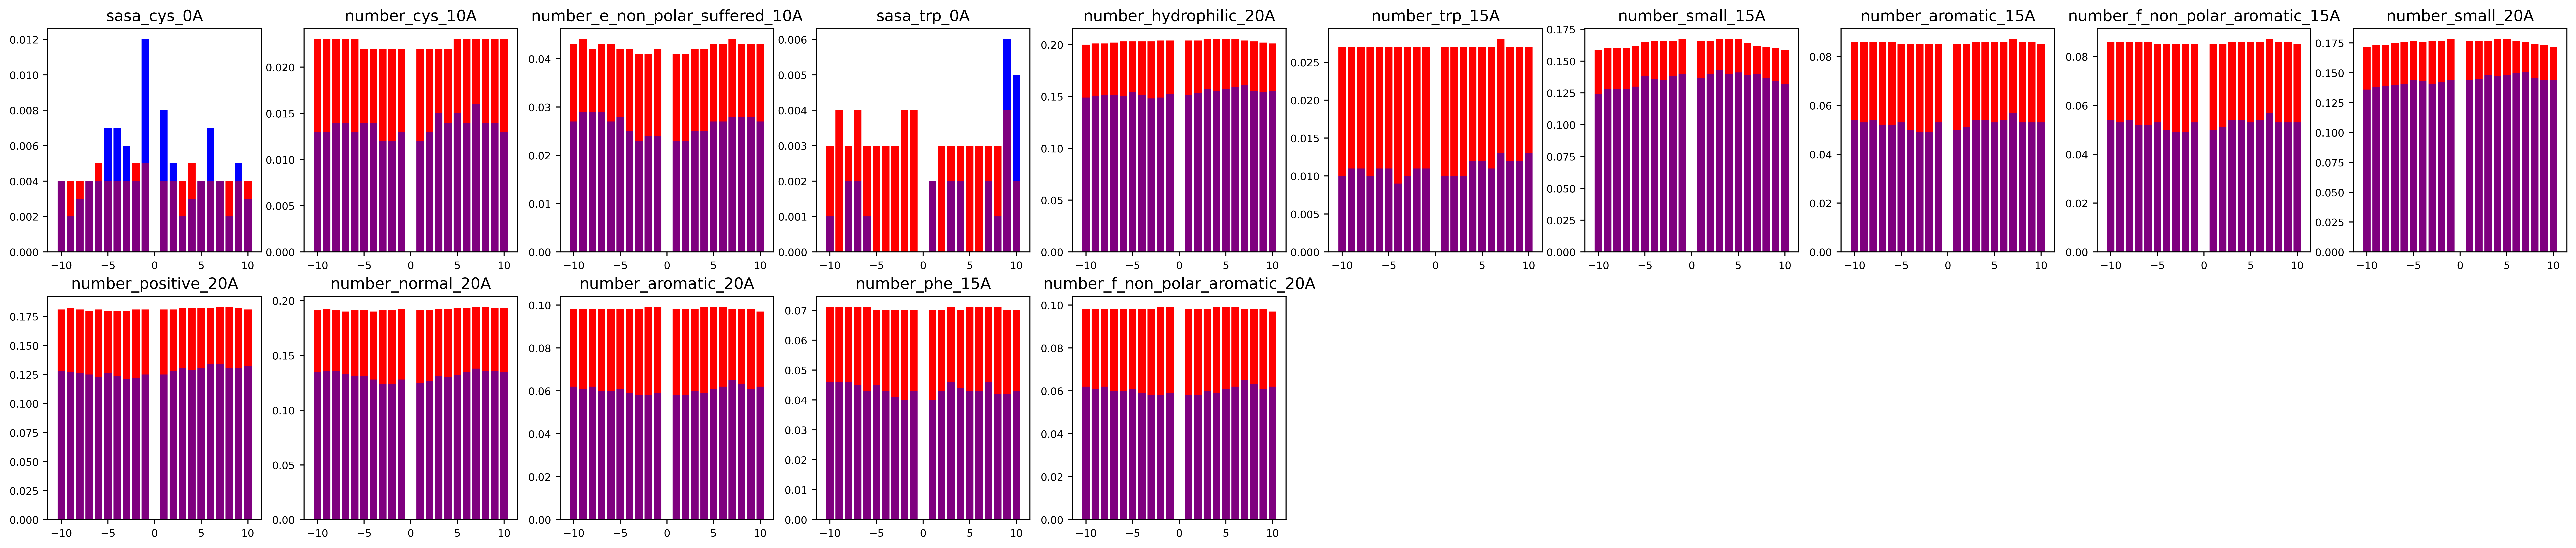

In [11]:
plt.figure(figsize=(3.5*10, 3.5*2), dpi=500)

alpha = 0.5
ylim = (0, 1)

for i, x in enumerate(selected_features):
    plt.subplot(2, 10, i+1)
    for idx in pos_df.index:
        if idx == 0:
            continue
        pos = pos_df.loc[idx, x]
        neg = neg_df.loc[idx, x]
        is_pos_larger = pos > neg
        if is_pos_larger:
            plt.bar(idx, pos_df.loc[idx, x], color = 'b')
            plt.bar(idx, neg_df.loc[idx, x], color = 'r', alpha=alpha)
        else:
            plt.bar(idx, neg_df.loc[idx, x], color = 'r')
            plt.bar(idx, pos_df.loc[idx, x], color = 'b', alpha=alpha)
        
        
# plt.bar(pos_df.index, pos_df[x], alpha=0.5, color='b')
# plt.bar(neg_df.index, neg_df[x], alpha=0.5, color='r')

    setaxis(title=x)
# setlegend()

plt.show()